## ОПТИМИЗАЦИЯ ГИПЕРПАРАМЕТРОВ МОДЕЛИ (ПРАКТИКА)

### ОПИСАНИЕ ЗАДАЧИ

Практика основана на соревновании [Kaggle: Predicting a Biological Response](https://www.kaggle.com/c/bioresponse) (Прогнозирование биологического ответа).

**ЦЕЛЬ**: Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).  

**ОПИСАНИЕ ДАННЫХ**: Данные представлены в формате CSV.  Каждая строка представляет молекулу.  
Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1];  
Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.  
Предварительная обработка не требуется, данные уже закодированы и нормализованы.

**ЧТО НАДО СДЕЛАТЬ**: Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.  

**МЕТРИКА**: F1-score

****

1. ИМПОРТ БИБЛИОТЕК

In [1]:
import pandas as pd #для анализа и предобработки данных
import numpy as np #для матричных вычислений
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели (для логистической регрессии)
from sklearn import ensemble #ансамбли (для случайного леса)
from sklearn import metrics #метрики
from sklearn.model_selection import train_test_split #разделение выборки выборки
from sklearn.model_selection import cross_val_score # для оценки кросс валидации

from sklearn.model_selection import GridSearchCV # оптимизатор
from sklearn.model_selection import RandomizedSearchCV # оптимизатор
import hyperopt # оптимизатор 
from hyperopt import hp, fmin, tpe, Trials, space_eval # необходимые для hyperplot функции
import optuna # оптимизатор

import warnings
warnings.filterwarnings("ignore")

2. ЧТЕНИЕ ДАННЫХ И ПРЕДОБРАБОТКА

In [2]:
df = pd.read_csv(r'data\_train_sem09 (1).csv')
df.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.shape

(3751, 1777)

In [4]:
# задаем имя целевого признака
target = 'Activity'

1    0.542255
0    0.457745
Name: Activity, dtype: float64

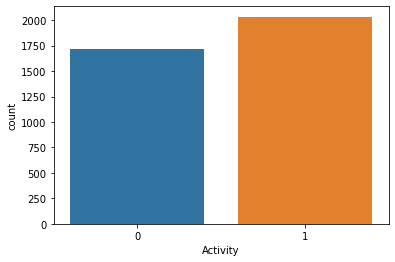

In [5]:
# проверим сбалансированность данных
display(df[target].value_counts(normalize=True))
sns.countplot(data=df, x=target);

Можно сказать, что выборка сбалансирована, но на всякий случай будем использовать стратификацию в сплите на тренировочную и тестовую выборки

In [6]:
# разделяем целевой признак от других наблюдений
X = df.drop([target], axis = 1)
y = df[target]

In [7]:
# создаем сплит на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.2)

3. ОПТИМИЗАЦИЯ ГИПЕРПАРАМЕТРОВ ДЛЯ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ

3.1 ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ БЕЗ ОПТИМИЗАЦИИ

In [8]:
# Посмотрим на метрику без оптимизации

log_reg = linear_model.LogisticRegression(max_iter = 1000)
log_reg.fit(X_train, y_train)
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)
print('Значение метрики без оптимизации')
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Значение метрики без оптимизации
f1_score на тренировочном наборе: 0.89
f1_score на тестовом наборе: 0.78


3.2 ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ С ОПТИМИЗАЦИЕЙ GRIDSEARCHCV

In [9]:
# Оптимизация GridSearchCV

param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # коэффициент 1/alpha (чем больше, тем меньше регуляриация)
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_grid=param_grid, 
    cv=5, # количество кросс-фолдов
    scoring='f1', # зададим сразу метрику f1
    n_jobs = -1
)
%time grid_search.fit(X_train, y_train) # запускаем оптимизацию

print('Значение метрики с оптимизацией GridSearchCV')
print("f1_score на тренировочном наборе: {:.2f}".format(grid_search.score(X_train, y_train)))
print("f1_score на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Наилучшие значения параметров: {}".format(grid_search.best_params_))


Wall time: 25min 12s
Значение метрики с оптимизацией GridSearchCV
f1_score на тренировочном наборе: 0.84
f1_score на тестовом наборе: 0.78
Наилучшие значения параметров: {'C': 0.3, 'penalty': 'l1', 'solver': 'liblinear'}


3.3 ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ С ОПТИМИЗАЦИЕЙ RANDOMIZEDSEARCHCV

In [10]:
# Оптимизация RandomizedSearchCV

param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # коэффициент 1/alpha (чем больше, тем меньше регуляриация)
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]

random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_grid, 
    cv=5, # количество кросс-фолдов
    scoring='f1', # зададим сразу метрику f1
    n_iter = 10, # в отличие от gridsearch задаем количество итераций (выборок параметров)
    n_jobs = -1
)              

%time random_search.fit(X_train, y_train) # запускаем оптимизацию

print('Значение метрики с оптимизацией RandomizedSearchCV')
print("f1_score на тренировочном наборе: {:.2f}".format(random_search.score(X_train, y_train)))
print("f1_score на тестовом наборе: {:.2f}".format(random_search.score(X_test, y_test)))
print("Наилучшие значения параметров: {}".format(random_search.best_params_))             

Wall time: 2min 4s
Значение метрики с оптимизацией GridSearchCV
f1_score на тренировочном наборе: 0.84
f1_score на тестовом наборе: 0.78
Наилучшие значения параметров: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.3}


3.3 ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ С ОПТИМИЗАЦИЕЙ HYPERPLOT

In [21]:
%%time
# Оптимизация hyperopt

# Задаем пространство поиска из двух вариантов оптимизатора в зависимости от возможных опций регуляризации
search_space = hp.choice('variant', [{
                'lr_penalty' : hp.choice(label='penalty_l2', options=['l2', 'none']),
                'lr_solver' : hp.choice(label='solver_l2', options=['lbfgs', 'sag']),
                'lr_C' : hp.uniform(label='C_l2', low=0.1, high=1)
                },
                {
                'lr_penalty' : hp.choice(label='penalty_l1', options=['l2', 'l1']),
                'lr_solver' : hp.choice(label='solver_l1', options=['liblinear', 'saga']),
                'lr_C' : hp.uniform(label='C_l1', low=0.1, high=1)   
                    
                }])

# Задаем функцию расчета метрики, которую необходимо минимизировать
def hyperopt_lr(params, cv=5, X=X_train, y=y_train, random_state=42):
    print(params)
    params = {'penalty' : params['lr_penalty'],
              'solver' : params['lr_solver'],
              'C': params['lr_C']             
              }
          
    model = linear_model.LogisticRegression(**params, random_state=random_state, max_iter=1000)
    # обучаем модель и считаем метрику на кросс-валидации
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score


# начинаем подбор гиперпараметров
trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_lr, # наша функция 
          space=search_space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=10, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(42)# фиксируем для повторяемости результата
         )

print("Наилучшие значения гиперпараметров {}".format(space_eval(search_space, best)))

{'lr_C': 0.8955339629253539, 'lr_penalty': 'none', 'lr_solver': 'sag'}
{'lr_C': 0.8748374337220912, 'lr_penalty': 'l2', 'lr_solver': 'liblinear'}        
{'lr_C': 0.6558947661457027, 'lr_penalty': 'l2', 'lr_solver': 'lbfgs'}            
{'lr_C': 0.6332080719932267, 'lr_penalty': 'l2', 'lr_solver': 'liblinear'}       
{'lr_C': 0.35862068786791046, 'lr_penalty': 'none', 'lr_solver': 'sag'}          
{'lr_C': 0.49774905851720797, 'lr_penalty': 'l2', 'lr_solver': 'saga'}           
{'lr_C': 0.17357224775694025, 'lr_penalty': 'l2', 'lr_solver': 'saga'}           
{'lr_C': 0.7732321956643607, 'lr_penalty': 'none', 'lr_solver': 'lbfgs'}         
{'lr_C': 0.1486700869997656, 'lr_penalty': 'l2', 'lr_solver': 'sag'}             
{'lr_C': 0.49149815828572563, 'lr_penalty': 'l2', 'lr_solver': 'liblinear'}      
100%|██████████| 10/10 [10:37<00:00, 63.79s/trial, best loss: -0.7828415027113358]
Наилучшие значения гиперпараметров {'lr_C': 0.17357224775694025, 'lr_penalty': 'l2', 'lr_solver': 'saga'}


In [22]:
# рассчитаем точность для тестовой выборки

model = linear_model.LogisticRegression(
    solver = space_eval(search_space, best)['lr_solver'],
    penalty =  space_eval(search_space, best)['lr_penalty'],
    C = space_eval(search_space, best)['lr_C'],
    random_state=42,
    max_iter=1000)

model.fit(X_train, y_train) # обучаем модель

print('Значение метрики с оптимизацией HyperOpt')
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("f1_score на тренировочном наборе: {:.2f}".format(metrics.f1_score(y_train, y_train_pred)))
print("f1_score на тестовом наборе: {:.2f}".format(metrics.f1_score(y_test, y_test_pred)))    

Значение метрики с оптимизацией HyperOpt
f1_score на тренировочном наборе: 0.86
f1_score на тестовом наборе: 0.78


3.4 ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ С ОПТИМИЗАЦИЕЙ OPTUNA

In [30]:
%%time
# Оптимизация optuna

# Задаем функцию расчета метрики, которую необходимо минимизировать/максимизировать
def optuna_lr(trial):
    # задаем пространства поиска гиперпараметров
    solvers = trial.suggest_categorical('solvers', ['lbfgs', 'sag', 'liblinear', 'saga'])
    if solvers in ['lbfgs', 'sag']:
        penalties = trial.suggest_categorical('penalties1', ['l2', 'none'])
    else:
        penalties = trial.suggest_categorical('penalties2', ['l2', 'l1'])
    Сs = trial.suggest_float('Cs', 0.1, 1)
    
  
    # создаем модель
    model = linear_model.LogisticRegression(solver=solvers,
                                          penalty=penalties,
                                          C=Сs,
                                          random_state=42,
                                          max_iter=1000)
    # обучаем модель и считаем метрику на кросс-валидации
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
    return score

# cоздаем объект исследования
study = optuna.create_study(study_name="Logistic Regression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lr, n_trials=10)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

[I 2022-09-15 23:55:25,188] A new study created in memory with name: Logistic Regression
[I 2022-09-15 23:57:04,271] Trial 0 finished with value: 0.777611123141015 and parameters: {'solvers': 'sag', 'penalties1': 'l2', 'Cs': 0.3032391024163998}. Best is trial 0 with value: 0.777611123141015.
[I 2022-09-15 23:57:07,034] Trial 1 finished with value: 0.7881100496695017 and parameters: {'solvers': 'liblinear', 'penalties2': 'l1', 'Cs': 0.3811805129587813}. Best is trial 1 with value: 0.7881100496695017.
[I 2022-09-15 23:58:06,476] Trial 2 finished with value: 0.7832968499950418 and parameters: {'solvers': 'saga', 'penalties2': 'l2', 'Cs': 0.14615474875072015}. Best is trial 1 with value: 0.7881100496695017.
[I 2022-09-15 23:58:16,791] Trial 3 finished with value: 0.7761074144915423 and parameters: {'solvers': 'lbfgs', 'penalties1': 'l2', 'Cs': 0.8726804482260719}. Best is trial 1 with value: 0.7881100496695017.
[I 2022-09-15 23:59:30,665] Trial 4 finished with value: 0.7836253976048815 and

Наилучшие значения гиперпараметров {'solvers': 'saga', 'penalties2': 'l1', 'Cs': 0.153009693168219}
f1_score на обучающем наборе: 0.79
Wall time: 7min 34s


In [35]:
# рассчитаем точность для тестовой выборки

if 'penalties1' in study.best_params.keys():
    penalty = study.best_params['penalties1']
else:
    penalty = study.best_params['penalties2']

model = linear_model.LogisticRegression(
    solver = study.best_params['solvers'],
    penalty =  penalty,
    C = study.best_params['Cs'],
    random_state=42,
    max_iter=1000)

model.fit(X_train, y_train) # обучаем модель

print('Значение метрики с оптимизацией Optuna')
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("f1_score на тренировочном наборе: {:.2f}".format(metrics.f1_score(y_train, y_train_pred)))
print("f1_score на тестовом наборе: {:.2f}".format(metrics.f1_score(y_test, y_test_pred)))   

Значение метрики с оптимизацией Optuna
f1_score на тренировочном наборе: 0.82
f1_score на тестовом наборе: 0.77


4. ОПТИМИЗАЦИЯ ГИПЕРПАРАМЕТРОВ ДЛЯ СЛУЧАЙНОГО ЛЕСА

4.1 СЛУЧАЙНЫЙ ЛЕС БЕЗ ОПТИМИЗАЦИИ

In [38]:
# Посмотрим на метрику без оптимизации

rf = ensemble.RandomForestClassifier(random_state=42)

rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
print('Значение метрики без оптимизации')
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


Значение метрики без оптимизации
f1_score на тренировочном наборе: 1.00
f1_score на тестовом наборе: 0.80


4.2 СЛУЧАЙНЫЙ ЛЕС С ОПТИМИЗАЦИЕЙ GRIDSEARCHCV

In [46]:
# Оптимизация GridSearchCV

param_grid = {
            'n_estimators': list(range(50, 200, 25)),
            'min_samples_leaf': [5,7],
            'max_depth': list(np.linspace(20, 40, 5, dtype=int))
}
grid_search = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, # количество кросс-фолдов
    scoring='f1', # зададим сразу метрику f1
    n_jobs = -1
)
%time grid_search.fit(X_train, y_train) # запускаем оптимизацию

print('Значение метрики с оптимизацией GridSearchCV')
print("f1_score на тренировочном наборе: {:.2f}".format(grid_search.score(X_train, y_train)))
print("f1_score на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Наилучшие значения параметров: {}".format(grid_search.best_params_))


Wall time: 4min 40s
Значение метрики с оптимизацией GridSearchCV
f1_score на тренировочном наборе: 0.95
f1_score на тестовом наборе: 0.80
Наилучшие значения параметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 175}


4.3 СЛУЧАЙНЫЙ ЛЕС С ОПТИМИЗАЦИЕЙ RANDOMIZEDSEARCHCV

In [48]:
# Оптимизация RandomizedSearchCV

param_grid = param_grid = {
            'n_estimators': list(range(50, 200, 25)),
            'min_samples_leaf': [5,7],
            'max_depth': list(np.linspace(20, 40, 5, dtype=int))
}

random_search = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_grid, 
    cv=5, # количество кросс-фолдов
    scoring='f1', # зададим сразу метрику f1
    n_iter = 10, # в отличие от gridsearch задаем количество итераций (выборок параметров)
    n_jobs = -1
)              

%time random_search.fit(X_train, y_train) # запускаем оптимизацию

print('Значение метрики с оптимизацией RandomizedSearchCV')
print("f1_score на тренировочном наборе: {:.2f}".format(random_search.score(X_train, y_train)))
print("f1_score на тестовом наборе: {:.2f}".format(random_search.score(X_test, y_test)))
print("Наилучшие значения параметров: {}".format(random_search.best_params_))         

Wall time: 49.9 s
Значение метрики с оптимизацией RandomizedSearchCV
f1_score на тренировочном наборе: 0.94
f1_score на тестовом наборе: 0.80
Наилучшие значения параметров: {'n_estimators': 150, 'min_samples_leaf': 5, 'max_depth': 30}


4.3 СЛУЧАЙНЫЙ ЛЕС С ОПТИМИЗАЦИЕЙ HYPEROPT

In [55]:
%%time
# Оптимизация hyperopt

# Задаем пространство поиска 
search_space = {'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
       'max_depth' : hp.quniform('max_depth', 20, 40, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 5, 10, 1)
      }

# Задаем функцию расчета метрики, которую необходимо минимизировать
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=42):
    
    params = {'n_estimators' : int(params['n_estimators']),
              'max_depth' : int(params['max_depth']),
              'min_samples_leaf': int(params['min_samples_leaf'])             
              }
    
    model = ensemble.RandomForestClassifier(**params, random_state=42)
    # обучаем модель и считаем метрику на кросс-валидации
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score


# начинаем подбор гиперпараметров
trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=search_space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=40, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(42)# фиксируем для повторяемости результата
         )

print("Наилучшие значения гиперпараметров {}".format(space_eval(search_space, best)))

100%|██████████| 40/40 [04:36<00:00,  6.92s/trial, best loss: -0.8131239122232721]
Наилучшие значения гиперпараметров {'max_depth': 28.0, 'min_samples_leaf': 6.0, 'n_estimators': 199.0}
Wall time: 4min 36s


In [56]:
# рассчитаем точность для тестовой выборки

model = ensemble.RandomForestClassifier(   
    n_estimators = int(best['n_estimators']),
    max_depth = int(best['max_depth']),
    min_samples_leaf = int(best['min_samples_leaf']),
    random_state=42)

model.fit(X_train, y_train) # обучаем модель

print('Значение метрики с оптимизацией HyperOpt')
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("f1_score на тренировочном наборе: {:.2f}".format(metrics.f1_score(y_train, y_train_pred)))
print("f1_score на тестовом наборе: {:.2f}".format(metrics.f1_score(y_test, y_test_pred)))    

Значение метрики с оптимизацией HyperOpt
f1_score на тренировочном наборе: 0.93
f1_score на тестовом наборе: 0.80


4.4 СЛУЧАЙНЫЙ ЛЕС С ОПТИМИЗАЦИЕЙ OPTUNA

In [59]:
%%time
# Оптимизация optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Задаем функцию расчета метрики, которую необходимо минимизировать/максимизировать
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 50, 200, 1)
    max_depth = trial.suggest_int('max_depth', 20, 40, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 10, 1)
    
  
    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
    # обучаем модель и считаем метрику на кросс-валидации
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
    return score

# cоздаем объект исследования
study = optuna.create_study(study_name="Random Forest", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=40)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 167, 'max_depth': 23, 'min_samples_leaf': 6}
f1_score на обучающем наборе: 0.81
Wall time: 4min 19s


In [61]:
# рассчитаем точность для тестовой выборки

model = ensemble.RandomForestClassifier(   
    **study.best_params,
    random_state=42)

model.fit(X_train, y_train) # обучаем модель

print('Значение метрики с оптимизацией Optuna')
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("f1_score на тренировочном наборе: {:.2f}".format(metrics.f1_score(y_train, y_train_pred)))
print("f1_score на тестовом наборе: {:.2f}".format(metrics.f1_score(y_test, y_test_pred)))    

Значение метрики с оптимизацией Optuna
f1_score на тренировочном наборе: 0.93
f1_score на тестовом наборе: 0.79


****
ВЫВОД
Оптимизация гиперпараметров не показала прироста метрики f1 для тестовой выборки для моделей логистический регрессии и случайного леса. Максимальное значение метрики (0.80) достигается во всех моделях случайного леса, за исключением оптимизированного Optuna. Optuna показал результат немного ниже (0.79).  
Логистическая регрессия предсказывала класс с точностью несколько хуже (f1 = 0.78), при этом Optuna также показала результат ниже остальных оптимизаторов (0.77).  
Минимальное время оптимизации было у RandomizeSearch для случайного леса (чуть менеьше минуты), максимальное (более 20 минут) у GridSearch.  
Модели случайного леса были более склонны к переобучению, показывая более высокие значения метрики на обучающей выборке.